# CIFAR-10 Baseline (Colab)

This notebook loads the repo, installs deps, optionally runs the trainer, and visualizes saved metrics.

In [15]:


# Setup: clone repo and install requirements
%cd /content  # go back to root
!git clone https://github.com/moe-project-uu/mixture-of-experts-project.git || true
%cd mixture-of-experts-project
%pip install -r requirements.txt

# 2) Use Colab’s preinstalled torch to avoid CUDA mismatches
#    (so don't reinstall torch/torchvision). Install your package + other deps.
%pip install -U pip
%pip install -e .


[Errno 2] No such file or directory: '/content # go back to root'
/content/mixture-of-experts-project
Cloning into 'mixture-of-experts-project'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 310 (delta 37), reused 68 (delta 23), pack-reused 215 (from 1)
Receiving objects: 100% (310/310), 22.05 MiB | 9.02 MiB/s, done.
Resolving deltas: 100% (132/132), done.
/content/mixture-of-experts-project/mixture-of-experts-project
Obtaining file:///content/mixture-of-experts-project/mixture-of-experts-project
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mixture-of-experts-project (pyproject.toml) ... done
  Created wheel for mixture-of-experts-project: filename=mixture_of_experts_project-0.0.1-0.editable-py3-non

In [17]:
%cd /content/mixture-of-experts-project
!git restore scripts/train_cifar10.py     # discard local changes to that file
!git checkout arokah                     # now it’ll work
!git pull                                # fetch latest commits


/content/mixture-of-experts-project
Branch 'arokah' set up to track remote branch 'arokah' from 'origin'.
Switched to a new branch 'arokah'
Already up to date.


In [18]:
# CELL2: Train via CLI so argparse is used
%cd /content/mixture-of-experts-project

# config settings
FF_LAYER = "SoftMoE"   # "Dense" or "SoftMoE"
EPOCHS   = 100
NUM_EXPERTS = 4        # ignored for Dense

if FF_LAYER == "Dense":
    !python scripts/train_cifar10.py --FF_layer Dense --epochs {EPOCHS}
else:
    !python scripts/train_cifar10.py --FF_layer SoftMoE --epochs {EPOCHS} --num_experts {NUM_EXPERTS}


/content/mixture-of-experts-project
dataloaders metadata: {'mean': (0.4914, 0.4822, 0.4465), 'std': (0.247, 0.2435, 0.2616), 'num_classes': 10, 'sizes': {'train': 45000, 'val': 5000, 'test': 10000}}
Epoch 1/100: 100% 352/352 [00:06<00:00, 50.55it/s]
Epoch 001/100 | train_loss=1.9323 train_acc=22.58% | val_loss=1.8789 val_acc=25.88%
Saved checkpoint: SoftMoE val_acc=25.88%
Epoch 2/100: 100% 352/352 [00:06<00:00, 58.62it/s]
Epoch 002/100 | train_loss=1.6915 train_acc=33.25% | val_loss=1.7019 val_acc=36.70%
Saved checkpoint: SoftMoE val_acc=36.70%
Epoch 3/100: 100% 352/352 [00:05<00:00, 58.99it/s]
Epoch 003/100 | train_loss=1.4759 train_acc=43.02% | val_loss=1.3277 val_acc=51.68%
Saved checkpoint: SoftMoE val_acc=51.68%
Epoch 4/100: 100% 352/352 [00:05<00:00, 59.74it/s]
Epoch 004/100 | train_loss=1.3058 train_acc=48.18% | val_loss=1.3229 val_acc=52.30%
Saved checkpoint: SoftMoE val_acc=52.30%
Epoch 5/100: 100% 352/352 [00:05<00:00, 59.62it/s]
Epoch 005/100 | train_loss=1.1914 train_acc=54

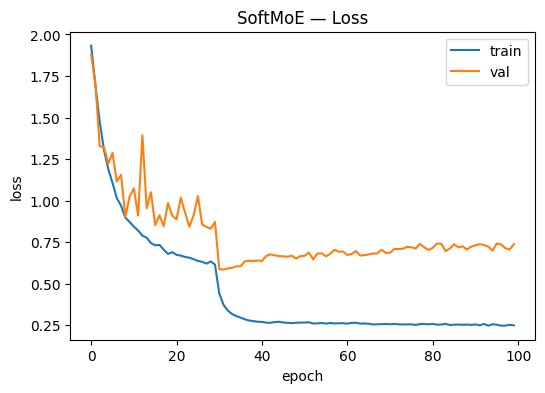

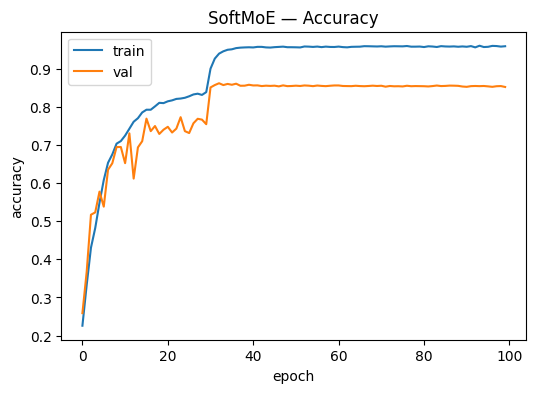

In [20]:
# CELL3: Load metrics.pt and plot loss/accuracy
import os, torch, numpy as np
import matplotlib.pyplot as plt

FF_LAYER = "SoftMoE"   # must match CELL2
EPOCHS   = 100
NUM_EXPERTS = 4        # only used if not Dense

run_tag = f"E{EPOCHS}" if FF_LAYER == "Dense" else f"E{EPOCHS}-X{NUM_EXPERTS}"
ckpt_dir = os.path.join("/content/mixture-of-experts-project", "checkpoints", FF_LAYER, run_tag)
metrics_path = os.path.join(ckpt_dir, "metrics.pt")
assert os.path.exists(metrics_path), f"metrics.pt not found at {metrics_path}"

#load hist dict from metrics.pt
hist = torch.load(metrics_path, map_location="cpu", weights_only=False)

train_loss = np.array(hist["train_loss"])
train_acc  = np.array(hist["train_acc"])
val_loss   = np.array(hist["val_loss"])
val_acc    = np.array(hist["val_acc"])

plt.figure(figsize=(6,4))
plt.plot(train_loss, label="train")
plt.plot(val_loss,   label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title(f"{FF_LAYER} — Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_acc, label="train")
plt.plot(val_acc,   label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title(f"{FF_LAYER} — Accuracy"); plt.legend(); plt.show()


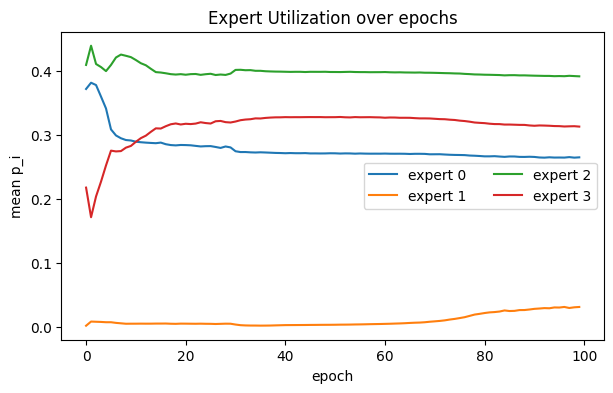

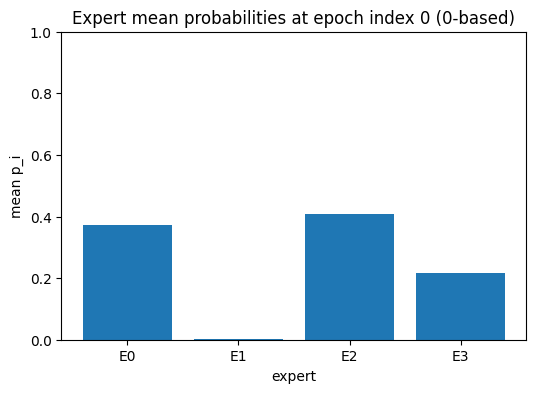

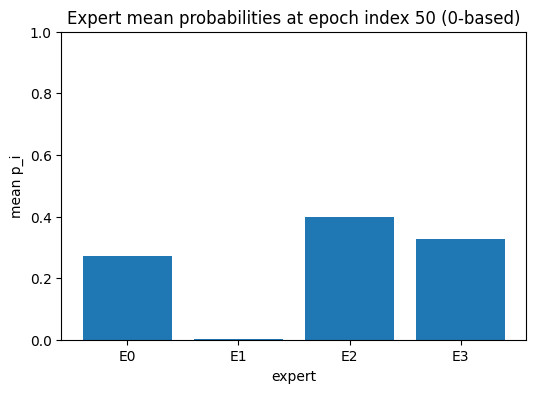

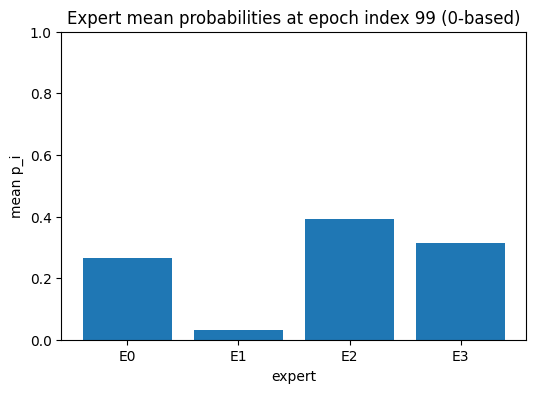

In [22]:
# CELL4: SoftMoE — Expert Utilization (lines + per-epoch bars)
import numpy as np
import matplotlib.pyplot as plt

if FF_LAYER != "SoftMoE":
    print("Utilization plots are only available for SoftMoE.")
else:
    util_list = hist.get("util_per_epoch", [])
    if len(util_list) == 0:
        print("No utilization recorded. Make sure you trained with SoftMoE.")
    else:
        util = np.stack(util_list, axis=0)  # shape (num_epochs, num_experts)

        # (A) Line plot: evolution over epochs
        plt.figure(figsize=(7,4))
        for i in range(util.shape[1]):
            plt.plot(util[:, i], label=f"expert {i}")
        plt.xlabel("epoch"); plt.ylabel("mean p_i")
        plt.title("Expert Utilization over epochs")
        plt.legend(ncol=2); plt.show()

        # (B) Bars at epochs 0, 50, 100 (0-based indices)
        requested = [0, 50, 99]
        max_idx = util.shape[0] - 1
        picked = [e for e in requested if 0 <= e <= max_idx]

        for e in picked:
            vals = util[e]  # length = num_experts
            plt.figure(figsize=(6,4))
            plt.bar(np.arange(len(vals)), vals)
            plt.xticks(np.arange(len(vals)), [f"E{i}" for i in range(len(vals))])
            plt.ylim(0, 1)
            plt.ylabel("mean p_i"); plt.xlabel("expert")
            plt.title(f"Expert mean probabilities at epoch index {e} (0-based)")
            plt.show()


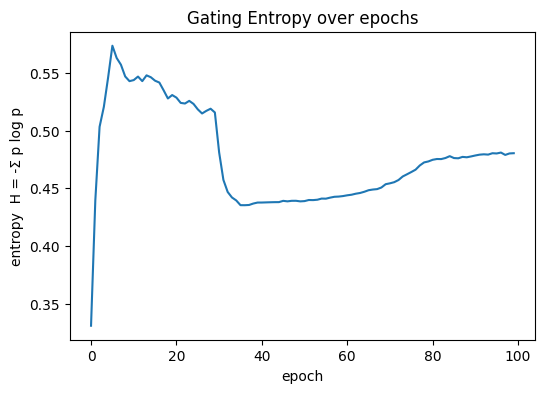

In [23]:
# CELL5: SoftMoE — Gating Entropy over epochs
import numpy as np
import matplotlib.pyplot as plt

if FF_LAYER != "SoftMoE":
    print("Entropy plot is only available for SoftMoE.")
else:
    H = np.array(hist.get("entropy_per_epoch", []))
    if H.size == 0:
        print("No entropy recorded. Make sure you trained with SoftMoE.")
    else:
        plt.figure(figsize=(6,4))
        plt.plot(H)
        plt.xlabel("epoch"); plt.ylabel("entropy  H = -Σ p log p")
        plt.title("Gating Entropy over epochs")
        plt.show()
